# Classifier model evaluation
This notebook demonstrates some basic techniques to evaluate classifier models, such as Random forest classifier, Logistic regression or Gradient boosting classifier.

The performed example evaluation here can be divided into 3 parts:
- Evaluating the predicted probabilities
- Evaluating the default label classifications
- Defining custom classification thresholds and evaluating the results

A randomly generated dataset is used for demonstration.

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from eis_toolkit.prediction.random_forests import random_forest_classifier_train
from eis_toolkit.prediction.machine_learning_predict import predict_classifier
from eis_toolkit.validation.plot_confusion_matrix import plot_confusion_matrix
from eis_toolkit.validation.classification_label_evaluation import summarize_label_metrics_binary, confusion_matrix
from eis_toolkit.validation.classification_probability_evaluation import (
    plot_calibration_curve, plot_precision_recall_curve, plot_det_curve, plot_roc_curve, summarize_probability_metrics,
    plot_predicted_probability_distribution
)

In [214]:
# Creating a test dataset and classification
X, y = make_classification(n_samples=100, n_features=10, n_redundant=4, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
rf_model, history = random_forest_classifier_train(X_train, y_train)
y_pred, y_prob_all = predict_classifier(X_test, rf_model, include_probabilities=True)

## Probability array evaluation
Classifier models included in EIS Toolkit can be used to get a probability array(s). The probability array of the interesting label (in binary case, 1 which correspond to positive/deposit occurance in MPM) can be extracted and evaluated.

Applicable evaluation techniques include calculating metrics, such as ROC AUC, log loss, average precision and Brier score loss, and plotting curves such as ROC curve, DET curve, precision-recall curve and calibration curve.

Additionally, the probability array can be used to manually classify using custom thresholds by simply assinging array values 1 or 0 based on whether the value is over or below the defined probability threshold. Example of this is at the bottom of this notebook.

In [215]:
# Extracting the probability array for label 1, which corresponds to mineral deposit occurance
y_prob = y_prob_all[:, 1]

In [216]:
prob_metrics = summarize_probability_metrics(y_test, y_prob)
prob_metrics

{'roc_auc': 0.88,
 'log_loss': 0.38186469406400503,
 'average_precision': 0.9189194139194139,
 'brier_score_loss': 0.10546400000000002}

<Axes: title={'center': 'ROC curve'}, xlabel='False positive rate', ylabel='True positive rate'>

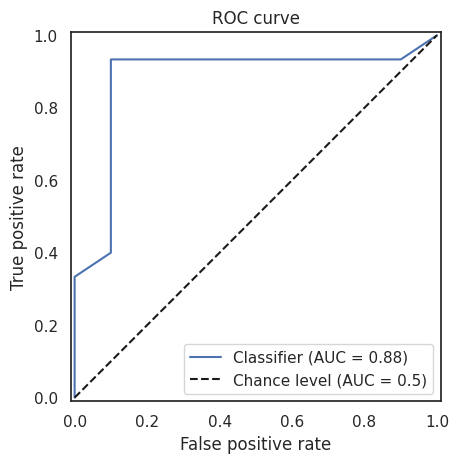

In [217]:
plot_roc_curve(y_test, y_prob)

<Axes: title={'center': 'DET curve'}, xlabel='False positive rate', ylabel='True positive rate'>

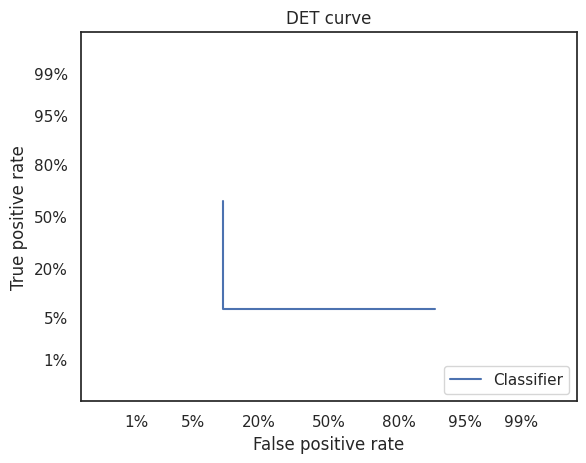

In [218]:
plot_det_curve(y_test, y_prob)

<Axes: title={'center': 'Precision-Recall curve'}, xlabel='False positive rate', ylabel='True positive rate'>

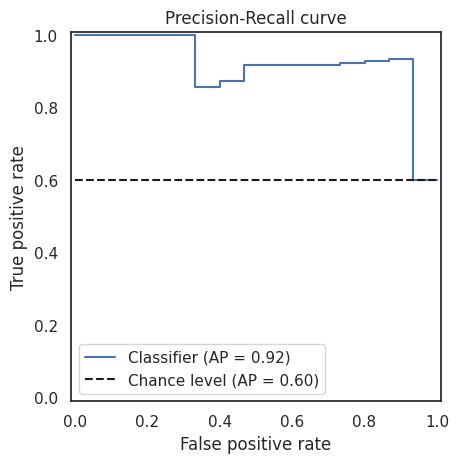

In [219]:
plot_precision_recall_curve(y_test, y_prob)

<Axes: title={'center': 'Calibration curve'}, xlabel='Mean predicted probability', ylabel='Fraction of positives'>

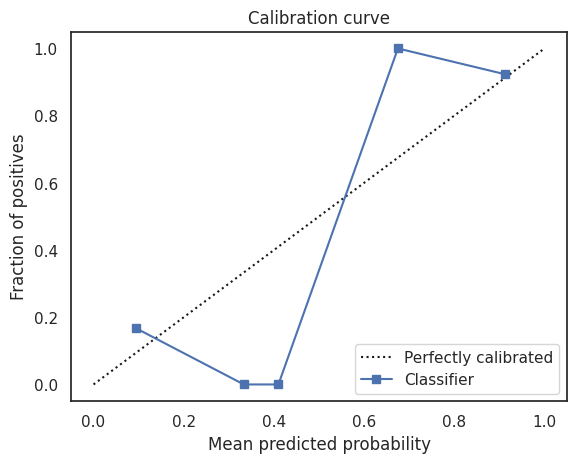

In [220]:
plot_calibration_curve(y_test, y_prob)

<Axes: title={'center': 'Distribution of predicted probabilities'}, xlabel='Predicted probability', ylabel='Count'>

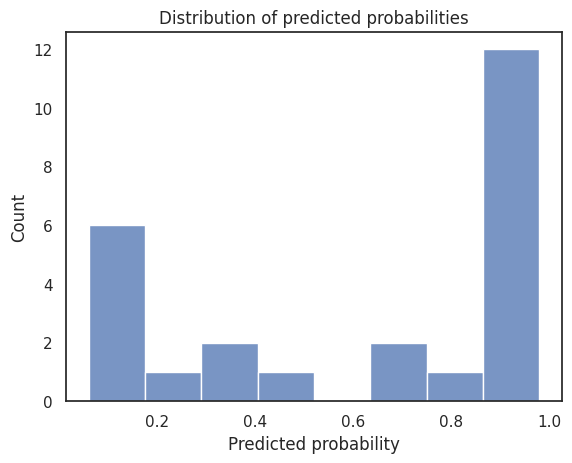

In [221]:
plot_predicted_probability_distribution(y_prob, n_bins=8)

## Label array evaluation
In binary classification, the label that has higher probability (i.e. over 50%) is assigned in the predicted label array. Basic evaluation can be done by inspecting some metrics and the confusion matrix.

In [222]:
label_metrics = summarize_label_metrics_binary(y_test, y_pred)
label_metrics

{'Accuracy': 0.92,
 'Precision': 0.9333333333333333,
 'Recall': 0.9333333333333333,
 'F1_score': 0.9333333333333333,
 'True_negatives': 9,
 'False_positives': 1,
 'False_negatives': 1,
 'True_positives': 14}

<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

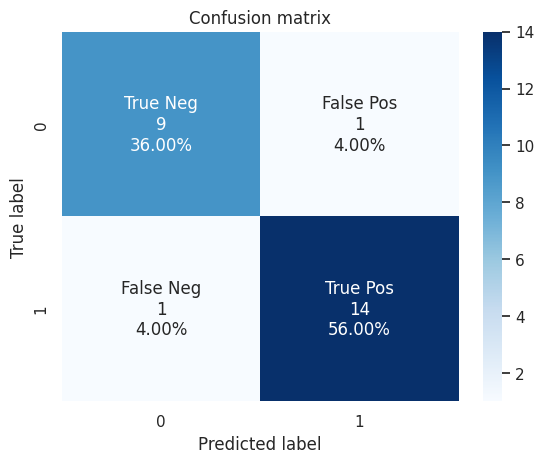

In [223]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), cmap="Blues")

## Thresholding the probability array

The probability array can be used to classify with custom thresholds in addition to the default 50% threshold (for binary case). The plots and metrics for the probability array might help in selecting a suitable threshold, but trying out different thresholds manually and scoring the results may be useful too.

Below the probability array is thresholded with classification thresholds 30%, 50% and 70%, and the confusion matrices and metrics compared.

In [224]:
y_pred_50 = y_pred.copy()
y_pred_50[y_prob >= 0.5] = 1
y_pred_50[y_prob < 0.5] = 0

In [225]:
y_pred_70 = y_pred.copy()
y_pred_70[y_prob >= 0.7] = 1
y_pred_70[y_prob < 0.7] = 0

In [226]:
y_pred_30 = y_pred.copy()
y_pred_30[y_prob >= 0.3] = 1
y_pred_30[y_prob < 0.3] = 0

<Axes: title={'center': '70% threshold'}, xlabel='Predicted label', ylabel='True label'>

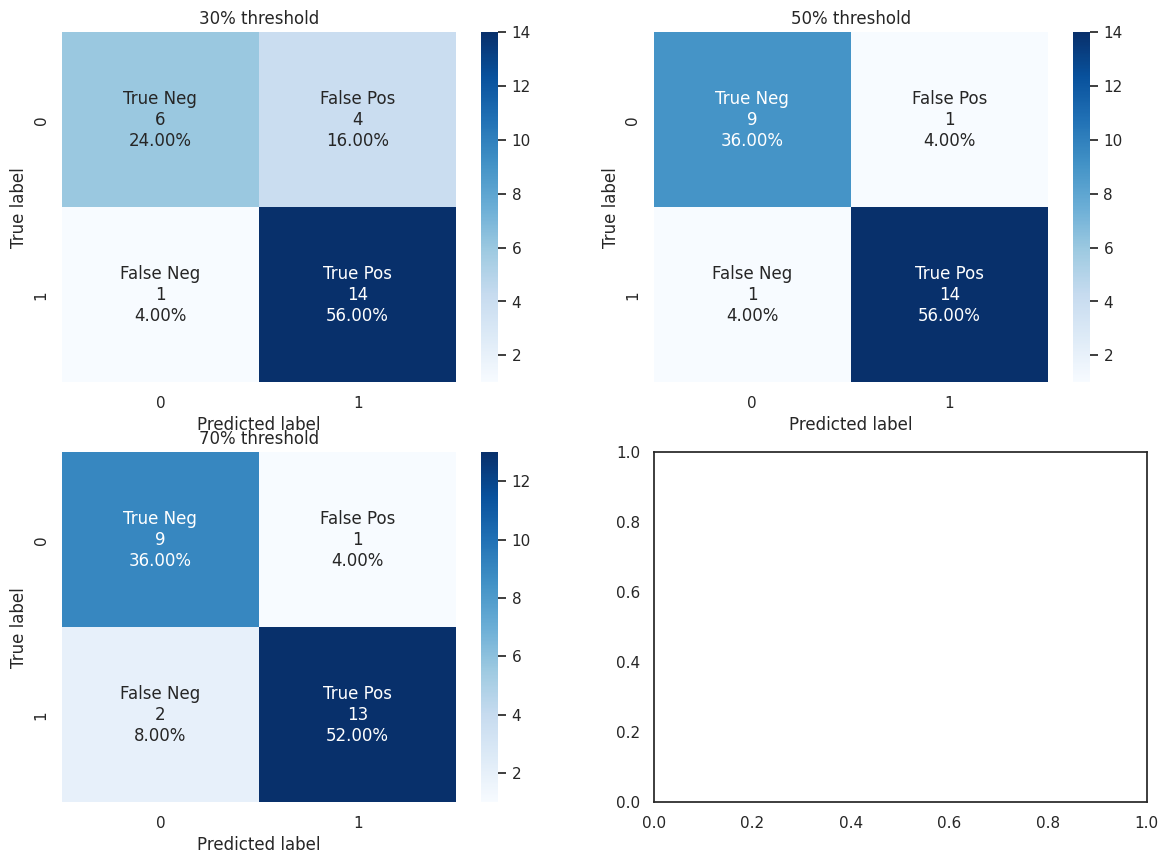

In [227]:
# Confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_confusion_matrix(confusion_matrix(y_test, y_pred_30), cmap="Blues", plot_title="30% threshold", ax=axs[0, 0])
plot_confusion_matrix(confusion_matrix(y_test, y_pred_50), cmap="Blues", plot_title="50% threshold", ax=axs[0, 1])
plot_confusion_matrix(confusion_matrix(y_test, y_pred_70), cmap="Blues", plot_title="70% threshold", ax=axs[1, 0])

In [228]:
# Metrics
label_metrics_30 = summarize_label_metrics_binary(y_test, y_pred_30)
label_metrics_50 = summarize_label_metrics_binary(y_test, y_pred_50)
label_metrics_70 = summarize_label_metrics_binary(y_test, y_pred_70)

df = pd.DataFrame([label_metrics_30, label_metrics_50, label_metrics_70])
df.index = ["30% Threshold", "50% Threshold", "70% Threshold"]
df

,Accuracy,Precision,Recall,F1_score,True_negatives,False_positives,False_negatives,True_positives
30% Threshold,0.80,0.777778,0.933333,0.848485,6,4,1,14
50% Threshold,0.92,0.933333,0.933333,0.933333,9,1,1,14
70% Threshold,0.88,0.928571,0.866667,0.896552,9,1,2,13
